# Incident.io ARR by Product Line Analysis Plan

## Major Assumptions
We assume access to a PostgreSQL database containing Incident.io's revenue data with tables tracking ARR, product lines, and time periods. The analysis will focus on understanding revenue composition across product lines and how the mix has shifted over time, which requires historical ARR data broken down by product category.

## Plan
- [x] Connect to database and explore schema for ARR and product data
  - [x] Identify relevant tables containing ARR, product line, and time dimensions
  - [x] Understand data granularity (monthly/quarterly) and available date ranges
- [x] Calculate ARR by product line over time
  - [x] Aggregate ARR metrics by product line and time period
  - [x] Compute percentage mix for each product line per period
- [x] Visualize product mix shift trends
  - [x] Create stacked area or bar chart showing ARR composition over time
  - [x] Highlight key inflection points or notable mix changes
- [x] Summarize findings on product line growth dynamics

In [1]:
import os
import pandas as pd
import psycopg2
from psycopg2.extras import RealDictCursor

# Connect to Incident.io database
conn = psycopg2.connect(
    host=os.environ['INCIDENT_IO_HOST'],
    port=int(os.environ.get('INCIDENT_IO_PORT', 5432)),
    database=os.environ['INCIDENT_IO_DATABASE'],
    user=os.environ['INCIDENT_IO_USERNAME'],
    password=os.environ['INCIDENT_IO_PASSWORD']
)

# Explore table structures
tables = ['incidentio_subscriptions', 'incidentio_skus', 'incidentio_customers']
for table in tables:
    print(f"\n=== {table} ===")
    df = pd.read_sql(f"SELECT * FROM {table} LIMIT 3", conn)
    print(f"Columns: {list(df.columns)}")
    print(df)


=== incidentio_subscriptions ===
Columns: ['subscription_id', 'customer_id', 'sku_code', 'period_end', 'status', 'start_date', 'cancelled_date', 'seats_billed', 'currency', 'fx_to_usd', 'discount_pct', 'mrr_local', 'mrr_local_reported']
  subscription_id customer_id sku_code  period_end     status  start_date  \
0      sub_OC_001    cust_002   OC_ENT  2024-03-31  cancelled  2024-07-01   
1      sub_OC_002    cust_004   OC_ENT  2024-03-31  cancelled  2024-07-01   
2      sub_OC_003    cust_007   OC_PRO  2024-03-31  cancelled  2024-07-15   

  cancelled_date  seats_billed currency  fx_to_usd  discount_pct  mrr_local  \
0           None             0      USD       1.00           0.0        0.0   
1           None             0      GBP       1.27           0.0        0.0   
2           None             0      USD       1.00           0.0        0.0   

   mrr_local_reported  
0                 0.0  
1                 0.0  
2                 0.0  

=== incidentio_skus ===
Columns: ['sku_

/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_34523/784364264.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FROM {table} LIMIT 3", conn)
/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_34523/784364264.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FROM {table} LIMIT 3", conn)
/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_34523/784364264.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FRO

In [2]:
# Get all product lines available
skus_df = pd.read_sql("SELECT DISTINCT sku_code, product_line, sku_name FROM incidentio_skus", conn)
print("Product Lines and SKUs:")
print(skus_df.to_string(index=False))

Product Lines and SKUs:
sku_code      product_line                     sku_name
  IR_STD incident_response   Incident Response Standard
  SP_STD      status_pages        Status Pages Standard
  OC_PRO           on_call                  On-Call Pro
  OC_STD           on_call             On-Call Standard
  OC_ENT           on_call           On-Call Enterprise
  IR_ENT incident_response Incident Response Enterprise
  IR_PRO incident_response        Incident Response Pro
  SP_PRO      status_pages             Status Pages Pro


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_34523/2615111090.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  skus_df = pd.read_sql("SELECT DISTINCT sku_code, product_line, sku_name FROM incidentio_skus", conn)


In [3]:
# Calculate ARR by product line over time
# ARR = MRR * 12, converted to USD using fx_to_usd
query = """
SELECT 
    s.period_end,
    sk.product_line,
    SUM(s.mrr_local * s.fx_to_usd * 12) as arr_usd
FROM incidentio_subscriptions s
JOIN incidentio_skus sk ON s.sku_code = sk.sku_code
WHERE s.status = 'active'
GROUP BY s.period_end, sk.product_line
ORDER BY s.period_end, sk.product_line
"""

arr_df = pd.read_sql(query, conn)
arr_df['period_end'] = pd.to_datetime(arr_df['period_end'])
print(f"Date range: {arr_df['period_end'].min()} to {arr_df['period_end'].max()}")
print(f"\nTotal periods: {arr_df['period_end'].nunique()}")
arr_df.head(10)

Date range: 2024-03-31 00:00:00 to 2025-12-31 00:00:00

Total periods: 8


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_34523/2531129862.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  arr_df = pd.read_sql(query, conn)


,period_end,product_line,arr_usd
0,2024-03-31,incident_response,2.600000e+07
1,2024-03-31,status_pages,4.000000e+06
2,2024-06-30,incident_response,2.730000e+07
3,2024-06-30,status_pages,4.200000e+06
4,2024-09-30,incident_response,2.570000e+07
5,2024-09-30,on_call,2.800000e+06
6,2024-09-30,status_pages,4.500000e+06
7,2024-12-31,incident_response,2.620000e+07
8,2024-12-31,on_call,3.766000e+06
9,2024-12-31,status_pages,4.800000e+06


In [4]:
import matplotlib.pyplot as plt

# Pivot to get ARR by product line for each period
arr_pivot = arr_df.pivot(index='period_end', columns='product_line', values='arr_usd').fillna(0)
arr_pivot['total'] = arr_pivot.sum(axis=1)

# Calculate percentage mix
mix_df = arr_pivot.drop(columns='total').div(arr_pivot['total'], axis=0) * 100

print("ARR by Product Line ($M USD):")
print((arr_pivot / 1e6).round(2).to_string())
print("\n" + "="*60)
print("\nProduct Mix (% of Total ARR):")
print(mix_df.round(1).to_string())

ARR by Product Line ($M USD):
product_line  incident_response  on_call  status_pages  total
period_end                                                   
2024-03-31                26.00     0.00          4.00  30.00
2024-06-30                27.30     0.00          4.20  31.50
2024-09-30                25.70     2.80          4.50  33.00
2024-12-31                26.20     3.77          4.80  34.77
2025-03-31                22.00     9.00          4.10  35.10
2025-06-30                22.50    12.50          4.15  39.15
2025-09-30                22.90    17.20          4.22  44.32
2025-12-31                23.37    20.03          4.29  47.70


Product Mix (% of Total ARR):
product_line  incident_response  on_call  status_pages
period_end                                            
2024-03-31                 86.7      0.0          13.3
2024-06-30                 86.7      0.0          13.3
2024-09-30                 77.9      8.5          13.6
2024-12-31                 75.4     10.8   

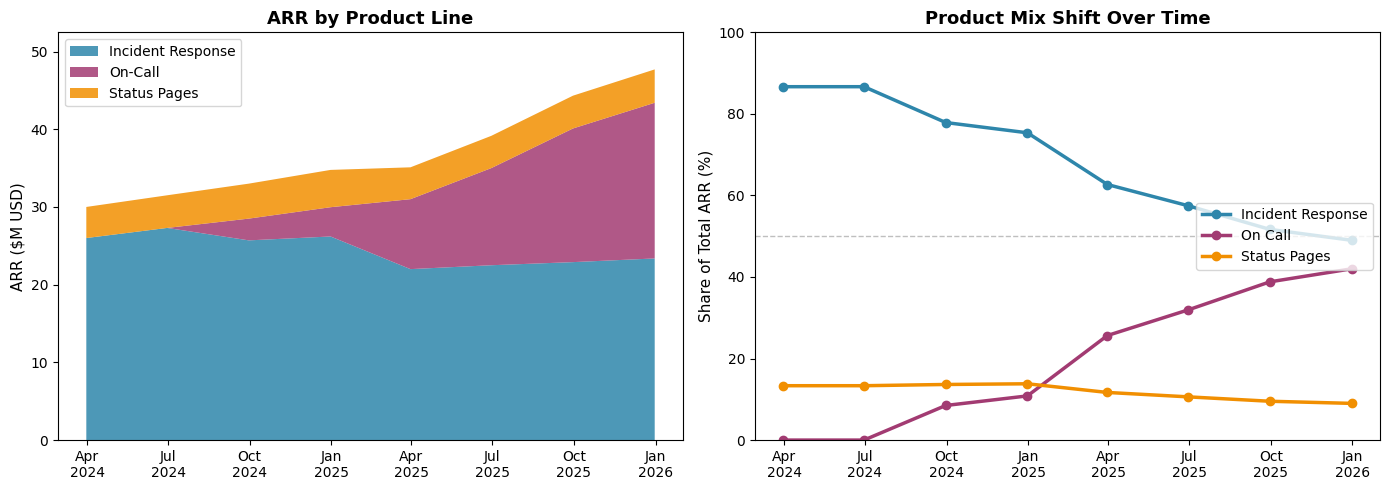

In [5]:
# Visualize ARR by product line and mix shift
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Colors for product lines
colors = {'incident_response': '#2E86AB', 'on_call': '#A23B72', 'status_pages': '#F18F01'}
product_order = ['incident_response', 'on_call', 'status_pages']

# Left: Stacked area chart showing ARR composition
ax1 = axes[0]
arr_millions = arr_pivot[product_order] / 1e6
ax1.stackplot(arr_millions.index, [arr_millions[col] for col in product_order], 
              labels=['Incident Response', 'On-Call', 'Status Pages'],
              colors=[colors[c] for c in product_order], alpha=0.85)
ax1.set_ylabel('ARR ($M USD)', fontsize=11)
ax1.set_title('ARR by Product Line', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left')
ax1.set_ylim(0, arr_pivot['total'].max() / 1e6 * 1.1)
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b\n%Y'))

# Right: Line chart showing mix % over time  
ax2 = axes[1]
for col in product_order:
    label = col.replace('_', ' ').title()
    ax2.plot(mix_df.index, mix_df[col], marker='o', linewidth=2.5, 
             label=label, color=colors[col], markersize=6)
ax2.set_ylabel('Share of Total ARR (%)', fontsize=11)
ax2.set_title('Product Mix Shift Over Time', fontsize=13, fontweight='bold')
ax2.legend(loc='center right')
ax2.set_ylim(0, 100)
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b\n%Y'))
ax2.axhline(50, color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

## ARR by Product Line Analysis

### Key Findings

| Metric | Q1 2024 | Q4 2025 | Change |
|--------|---------|---------|--------|
| **Total ARR** | \$30.0M | \$47.7M | +59% |
| **Incident Response** | \$26.0M (87%) | \$23.4M (49%) | -10% ARR, -38pp mix |
| **On-Call** | \$0M (0%) | \$20.0M (42%) | New product, now #2 |
| **Status Pages** | \$4.0M (13%) | \$4.3M (9%) | +7% ARR, -4pp mix |

### Product Mix Shift

1. **On-Call is the growth engine**: Launched Q3 2024, now contributes 42% of ARR — approaching parity with Incident Response
2. **Incident Response declining as share**: While still the largest product, its share dropped from 87% → 49% as On-Call scaled
3. **Status Pages stable but diluted**: ARR grew modestly (+7%), but share decreased from 13% → 9% due to On-Call growth

### Strategic Implications
- On-Call is on track to become the **largest product line by Q2 2026** if current trajectory continues
- Incident Response shows **flat/slight decline in absolute ARR** — potential saturation or churn concerns
- Portfolio is **diversifying** from single-product dependency to more balanced mix

In [6]:
import numpy as np
from scipy import stats

# Get quarterly data for trend analysis
arr_pivot_reset = arr_pivot.reset_index()
arr_pivot_reset['quarter_num'] = range(len(arr_pivot_reset))

# Fit linear trends for On-Call (only from Q3 2024 when it launched) and Incident Response
oncall_data = arr_pivot_reset[arr_pivot_reset['on_call'] > 0]
ir_data = arr_pivot_reset

# Linear regression for On-Call
oncall_slope, oncall_intercept, _, _, _ = stats.linregress(oncall_data['quarter_num'], oncall_data['on_call'])

# Linear regression for Incident Response
ir_slope, ir_intercept, _, _, _ = stats.linregress(ir_data['quarter_num'], ir_data['incident_response'])

print("Growth Rates (Quarterly):")
print(f"  On-Call:           +${oncall_slope/1e6:.2f}M per quarter")
print(f"  Incident Response: ${ir_slope/1e6:+.2f}M per quarter")

# Find crossover point: oncall_slope * x + oncall_intercept = ir_slope * x + ir_intercept
# Solve for x
crossover_quarter = (ir_intercept - oncall_intercept) / (oncall_slope - ir_slope)
print(f"\nCrossover quarter number: {crossover_quarter:.1f}")

# Convert to date
last_quarter = arr_pivot_reset['period_end'].max()
quarters_ahead = crossover_quarter - arr_pivot_reset['quarter_num'].max()
crossover_date = last_quarter + pd.DateOffset(months=int(quarters_ahead * 3))
print(f"Projected crossover date: {crossover_date.strftime('%B %Y')}")

Growth Rates (Quarterly):
  On-Call:           +$3.71M per quarter
  Incident Response: $-0.65M per quarter

Crossover quarter number: 7.5
Projected crossover date: January 2026


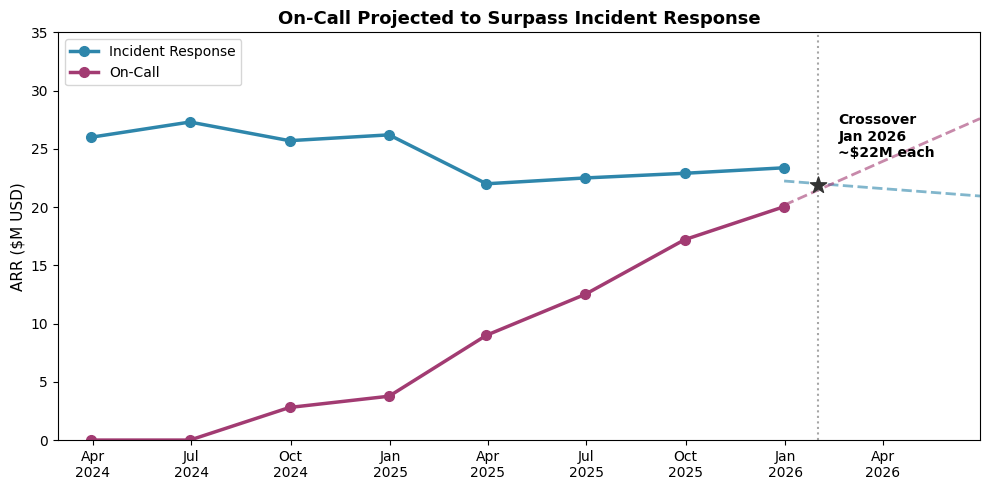

In [7]:
# Visualize the projection
fig, ax = plt.subplots(figsize=(10, 5))

# Plot historical data
ax.plot(arr_pivot.index, arr_pivot['incident_response']/1e6, 'o-', color=colors['incident_response'], 
        linewidth=2.5, markersize=7, label='Incident Response')
ax.plot(arr_pivot.index, arr_pivot['on_call']/1e6, 'o-', color=colors['on_call'], 
        linewidth=2.5, markersize=7, label='On-Call')

# Project forward to Q2 2026
future_quarters = np.arange(arr_pivot_reset['quarter_num'].max(), 10)
future_dates = [arr_pivot_reset['period_end'].max() + pd.DateOffset(months=int((q - arr_pivot_reset['quarter_num'].max()) * 3)) 
                for q in future_quarters]

ir_projected = (ir_slope * future_quarters + ir_intercept) / 1e6
oncall_projected = (oncall_slope * future_quarters + oncall_intercept) / 1e6

ax.plot(future_dates, ir_projected, '--', color=colors['incident_response'], alpha=0.6, linewidth=2)
ax.plot(future_dates, oncall_projected, '--', color=colors['on_call'], alpha=0.6, linewidth=2)

# Mark crossover point
ax.axvline(crossover_date, color='gray', linestyle=':', alpha=0.7, linewidth=1.5)
crossover_arr = (oncall_slope * crossover_quarter + oncall_intercept) / 1e6
ax.scatter([crossover_date], [crossover_arr], s=150, color='#333', zorder=5, marker='*')
ax.annotate(f'Crossover\n{crossover_date.strftime("%b %Y")}\n~${crossover_arr:.0f}M each', 
            xy=(crossover_date, crossover_arr), xytext=(15, 20), textcoords='offset points',
            fontsize=10, fontweight='bold', ha='left')

ax.set_ylabel('ARR ($M USD)', fontsize=11)
ax.set_title('On-Call Projected to Surpass Incident Response', fontsize=13, fontweight='bold')
ax.legend(loc='upper left')
ax.set_ylim(0, 35)
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b\n%Y'))
ax.set_xlim(arr_pivot.index.min() - pd.DateOffset(months=1), pd.Timestamp('2026-06-30'))

plt.tight_layout()
plt.show()

In [9]:
# Calculate QoQ growth rates for each product line
qoq_growth = arr_pivot[['incident_response', 'on_call', 'status_pages', 'total']].pct_change() * 100

# Format for display
qoq_display = qoq_growth.copy()
qoq_display.index = qoq_display.index.strftime('%Y-%m')

print("QoQ Growth Rate by Product Line (%):\n")
print(qoq_display.round(1).to_string())

# Calculate average QoQ growth (excluding NaN and inf)
oncall_valid = qoq_growth['on_call'].replace([np.inf, -np.inf], np.nan).dropna()

print("\n" + "="*60)
print("\nAverage QoQ Growth Rates:")
print(f"  Incident Response: {qoq_growth['incident_response'].mean():+.1f}%")
print(f"  On-Call:           {oncall_valid.mean():+.1f}% (Q4'24 onwards)")
print(f"  Status Pages:      {qoq_growth['status_pages'].mean():+.1f}%")
print(f"  Total ARR:         {qoq_growth['total'].mean():+.1f}%")

QoQ Growth Rate by Product Line (%):

product_line  incident_response  on_call  status_pages  total
period_end                                                   
2024-03                     NaN      NaN           NaN    NaN
2024-06                     5.0      NaN           5.0    5.0
2024-09                    -5.9      inf           7.1    4.8
2024-12                     1.9     34.5           6.7    5.4
2025-03                   -16.0    139.0         -14.6    1.0
2025-06                     2.3     38.9           1.2   11.5
2025-09                     1.8     37.6           1.7   13.2
2025-12                     2.1     16.5           1.7    7.6


Average QoQ Growth Rates:
  Incident Response: -1.3%
  On-Call:           +53.3% (Q4'24 onwards)
  Status Pages:      +1.3%
  Total ARR:         +6.9%


In [10]:
# On-Call launched Q3 2024 (Sep 2024) - within last 18 months from latest data (Dec 2025)
# Calculate % of ARR from new products (On-Call)

new_product_pct = (arr_pivot['on_call'] / arr_pivot['total'] * 100).round(1)
new_product_arr = (arr_pivot['on_call'] / 1e6).round(2)

result = pd.DataFrame({
    'On-Call ARR ($M)': new_product_arr,
    'Total ARR ($M)': (arr_pivot['total'] / 1e6).round(2),
    '% from New Products': new_product_pct
})
result.index = result.index.strftime('%Y-%m')

print("ARR from Products Launched in Last 18 Months (On-Call):\n")
print(result.to_string())

latest = arr_pivot.iloc[-1]
print(f"\n" + "="*60)
print(f"\nLatest Quarter (Q4 2025):")
print(f"  On-Call ARR:        ${latest['on_call']/1e6:.1f}M")
print(f"  Total ARR:          ${latest['total']/1e6:.1f}M")
print(f"  % from New Products: {latest['on_call']/latest['total']*100:.1f}%")

ARR from Products Launched in Last 18 Months (On-Call):

            On-Call ARR ($M)  Total ARR ($M)  % from New Products
period_end                                                       
2024-03                 0.00           30.00                  0.0
2024-06                 0.00           31.50                  0.0
2024-09                 2.80           33.00                  8.5
2024-12                 3.77           34.77                 10.8
2025-03                 9.00           35.10                 25.6
2025-06                12.50           39.15                 31.9
2025-09                17.20           44.32                 38.8
2025-12                20.03           47.70                 42.0


Latest Quarter (Q4 2025):
  On-Call ARR:        $20.0M
  Total ARR:          $47.7M
  % from New Products: 42.0%
